# Sklearn Pipeline Example
* [Resource](https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf)

In [2]:
## Improrting data
import pandas as pd
train = pd.read_csv(r'.\dataset\train_ctrUa4K.csv')
test = pd.read_csv(r'.\dataset\test_lAUu6dG.csv')
train = train.drop('Loan_ID', axis='columns')
train.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [3]:
# check class labels counts
print("Train labels")
print(train['Loan_Status'].value_counts())

Train labels
Y    422
N    192
Name: Loan_Status, dtype: int64


Clearly, there is huge class imbalance. So, first we need to balance the training data or we are gonna mess up the model pretty bad. For more info about this head [here](https://elitedatascience.com/imbalanced-classes).


## Handling Class Imbalance

### 1. Upsampling minority class

In [4]:
from sklearn.utils import resample

df = train.copy()
# Separate majority and minority classes
df_majority = df[df.Loan_Status=='Y']
df_minority = df[df.Loan_Status=='N']
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=422,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.Loan_Status.value_counts()

Y    422
N    422
Name: Loan_Status, dtype: int64

## 2. Downsampling majority class

In [5]:
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=192,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.Loan_Status.value_counts()

Y    192
N    192
Name: Loan_Status, dtype: int64

In [6]:
# I'll train only on one fo these, but feel free to try them all

# Actual Dataset
# X = train.drop('Loan_Status', axis='columns')
# y = train['Loan_Status']

# Upsampled Dataset
X = df_upsampled.drop('Loan_Status', axis='columns')
y = df_upsampled['Loan_Status']

# Downsampled Dataset
# X = df_downsampled.drop('Loan_Status', axis='columns')
# y = df_downsampled['Loan_Status']


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# sanity check
print(f"X_train.shape : {X_train.shape}")
print(f"X_test.shape : {X_test.shape}")
print(f"y_train.shape : {y_train.shape}")
print(f"y_test.shape : {y_test.shape}")


X_train.shape : (675, 11)
X_test.shape : (169, 11)
y_train.shape : (675,)
y_test.shape : (169,)


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')), # impute missing values by column median
        ('scaler', StandardScaler()) # scale values to 0-1 range
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # impute missing values with 'missing'
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [10]:
# get numeric and categorical features
numeric_features = train.select_dtypes(include=['int64', 'float64']).columns
print(f"numeric_features: {numeric_features}")
categorical_features = train.select_dtypes(include=['object']).drop(['Loan_Status'], axis=1).columns
print(f"categorical_features: {categorical_features}")

numeric_features: Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')
categorical_features: Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area'],
      dtype='object')


In [11]:
# use column transformer to preprocess different columns
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [12]:
preprocessor.fit_transform(X_train)[:1]

array([[-0.29123625, -0.47894872, -0.79986728, -4.38179372,  0.51845636,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ]])

In [13]:
# Creating a random forest classifier and fitting it to data
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier())
    ]
)

rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [14]:
print(X_train.shape)
# print(len(preds))
print(len(y_test.values))


(675, 11)
169


In [15]:
preds = rf.predict(X_train)
print(preds[:10])
# print(preds, len(preds), len(y_test), y_test)
rf.score(X_test, y_test.values)

['N' 'N' 'N' 'Y' 'Y' 'N' 'N' 'N' 'N' 'Y']


0.9112426035502958

In [16]:
# Using Gridsearch for hyperparameter tuning
param_grid = { 
    'classifier__n_estimators': [200, 500],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth' : [4,5,6,7,8],
    'classifier__criterion' :['gini', 'entropy']
}

from sklearn.model_selection import GridSearchCV
CV = GridSearchCV(rf, param_grid, n_jobs= -1)
                  
CV.fit(X_train, y_train)  
print(CV.best_params_)    
print(CV.best_score_)

{'classifier__criterion': 'gini', 'classifier__max_depth': 8, 'classifier__max_features': 'auto', 'classifier__n_estimators': 500}
0.8103703703703704


In [17]:
# Create a new classifer using the best parameters
# Creating a random forest classifier and fitting it to data
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(criterion='entropy', 
                                              max_depth=7,
                                              max_features='log2',
                                              n_estimators=500))
    ]
)

rf.fit(X_train, y_train)
print(f"Training Score: {rf.score(X_train, y_train)}")
print(f"Testing Score: {rf.score(X_test, y_test)}")


Training Score: 0.8933333333333333
Testing Score: 0.834319526627219


All the above process can also be done in a different way, using make_pipeline and make_column_transformer, key difference being, we won't need to pass name of the process. More about it can be find [here](https://jorisvandenbossche.github.io/blog/2018/05/28/scikit-learn-columntransformer/).

In [18]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

preprocessor2 = make_column_transformer(
    (
        # numeric_features,
        make_pipeline(
            SimpleImputer(), # left empty, will be used in grid search
            StandardScaler()
        ),
        numeric_features
    ),
    (
        # categorical_features,
        make_pipeline(
            SimpleImputer(strategy='constant', fill_value='missing'),
            OneHotEncoder(handle_unknown='ignore')
        ),
        categorical_features
    )
)

# check one of the preprocessed output
preprocessor2.fit_transform(X_train)[:1]

array([[-0.29123625, -0.47894872, -0.81117297, -4.37913606,  0.56709403,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ]])

In [19]:
# Random Forest Model
rf_model = make_pipeline(
    preprocessor2,
    RandomForestClassifier() # This will clearly overfit
)
rf_model.fit(X_train, y_train)
print(f"Training Score: {rf_model.score(X_train, y_train)}")
print(f"Testing Score: {rf_model.score(X_test, y_test)}")


Training Score: 1.0
Testing Score: 0.893491124260355


## Using GridSearch in Column Transformer

In [20]:
# create an empty parameter grid 
param_grid = {}
# Get a list of parameters that we can tune
grid_clf = GridSearchCV(rf_model, param_grid, cv=10, iid=False)
for val in grid_clf.estimator.get_params().keys():
    print(val)

memory
steps
verbose
columntransformer
randomforestclassifier
columntransformer__n_jobs
columntransformer__remainder
columntransformer__sparse_threshold
columntransformer__transformer_weights
columntransformer__transformers
columntransformer__verbose
columntransformer__pipeline-1
columntransformer__pipeline-2
columntransformer__pipeline-1__memory
columntransformer__pipeline-1__steps
columntransformer__pipeline-1__verbose
columntransformer__pipeline-1__simpleimputer
columntransformer__pipeline-1__standardscaler
columntransformer__pipeline-1__simpleimputer__add_indicator
columntransformer__pipeline-1__simpleimputer__copy
columntransformer__pipeline-1__simpleimputer__fill_value
columntransformer__pipeline-1__simpleimputer__missing_values
columntransformer__pipeline-1__simpleimputer__strategy
columntransformer__pipeline-1__simpleimputer__verbose
columntransformer__pipeline-1__standardscaler__copy
columntransformer__pipeline-1__standardscaler__with_mean
columntransformer__pipeline-1__standa

In [21]:
# create a parameter grid based on the parameters 
param_grid = {
    'columntransformer__pipeline-1__simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__n_estimators': [200, 500],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__max_depth' : [4,5,6,7,8],
    'randomforestclassifier__criterion' :['gini', 'entropy']
    }

In [22]:
grid_clf = GridSearchCV(estimator=rf_model, 
                        param_grid=param_grid, 
                        cv=3, # kfolds cross validation
                        n_jobs=-1, # use all processors
                        refit=True, # fit best classifier on train data at end, default=True
                        return_train_score=True)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                  

In [23]:
# print best model hyperparameters
print(grid_clf.best_params_)

{'columntransformer__pipeline-1__simpleimputer__strategy': 'median', 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__n_estimators': 200}


In [24]:
# print parameters of best model
best_model = grid_clf.best_estimator_
print(best_model)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                           

In [25]:
# print accuracy of best model on test data
print("best model from grid search: ", best_model.score(X_test, y_test))


best model from grid search:  0.8579881656804734


In [26]:
# save the best model
import joblib
joblib.dump(best_model, 'best_model.joblib')

['best_model.joblib']

In [27]:
# load saved model
import joblib
loaded_model = joblib.load('best_model.joblib')

In [28]:
# checking accuracy score via loaded model
print(loaded_model.score(X_test, y_test))

0.8579881656804734


Same as that of best_model. So, SUCCESS!

## Plotting Confusion Matrix

Confusion matrix, without normalization
[[67 18]
 [ 6 78]]
Normalized confusion matrix
[[0.78823529 0.21176471]
 [0.07142857 0.92857143]]


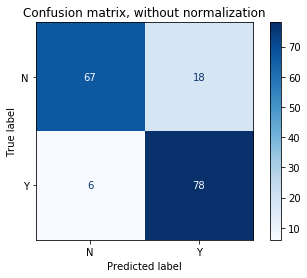

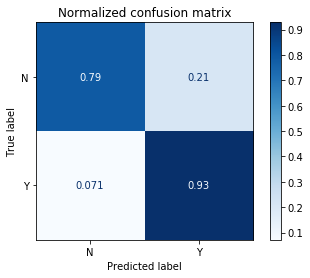

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(loaded_model, X_test, y_test,
                                #  display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()